# Mean-field:  The Hartree-Fock (HF) Approximation
## Honeycomb Latice Hubbard model

This notebook contains breif notes and several sample codes of the HF approximation for pedagogical purpose. The following text and codes are prepared by Mr.[Ting-Tung Wang](https://quantummc.xyz/members/ting-tung-wang/), Mr.[Menghan Song](https://quantummc.xyz/members/menghan-song/) and [ZYM](https://quantummc.xyz/members/ziyang-meng/). 

In this notebook, we present both the self-consistent method and the gradient decend method for obtaining the ground state of the Hubbard model. One may want to review [HF for square lattice](https://colab.research.google.com/github/songmengh/mean-field/blob/main/HF_Hubbard_square.ipynb) for more details.

This note utilise the following useful references:
1. [Lechermann, Model Hamiltonians and Basic Techniques](https://www.researchgate.net/publication/299842893_Model_Hamiltonians_and_Basic_Techniques)
2. [M.Raczkowski et al., Phys. Rev. B. 101, 125103 (2020)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.101.125103)
3. [H.Feldner, Z.Y.Meng et al., Phys. Rev. B. 81, 115416 (2010)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.115416)
4. [Hirsch, Phys. Rev. B 31, 4403 (1985)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.31.4403)

### 1. Hubbard model: Honeycomb Lattice

Considering the half-filling case, the Hamiltonian of the hubbard model is,

$$
H=-t\mathop{\sum}\limits_{\langle i,j \rangle \sigma}c_{i\sigma}^\dagger c_{j\sigma}+h.c.+U\mathop{\sum}\limits_i (n_{i\uparrow}-\frac{1}{2})(n_{i\downarrow}-\frac{1}{2})=H_T+H_U  \ \ \  (U>0),
$$
where $\langle i,j \rangle$ denotes the nearest neighbour hopping on the honeycomb(HC) lattice. 

The figure below shows the honeycomb lattice,


<img src="https://raw.githubusercontent.com/songmengh/mean-field/main/figures/HC_lattice.png" width=250 height=250/>

Here, one site has three nearest neighbours while it has four on the square lattice. And $\vec{a_1} ,\vec{a_2} $ are the two primitive vectors. $\vec{a_1}= \left ( \sqrt3/2,1/2 \right ) ,\vec{a_2}=\left ( \sqrt3/2,-1/2 \right )  $.

For the free fermion case, i.e. $U=0$, the dispersion relation is given by:
$$
E_k=\pm \sqrt{3+2 \cos \sqrt{3} k_y+4 \cos \left(\frac{3 k_x}{2}\right) \cos \left(\frac{\sqrt{3} k_y}{2}\right)}$$ as shown in the plot below.

<img src="https://raw.githubusercontent.com/songmengh/mean-field/main/figures/HC_disp.png" width=250 height=250/>

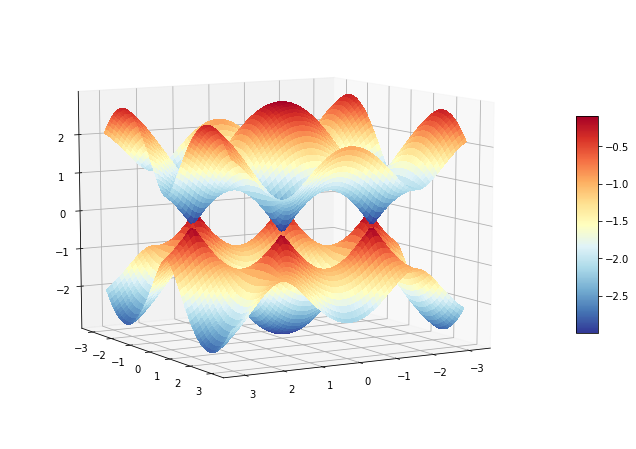

In [46]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

sqrt = np.sqrt
cos = np.cos

# Constants
d = np.sqrt(3)
t1 = 1
t3 = 0

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
x = np.arange(-1.0*np.pi, 1.0*np.pi, 0.05)
y = np.arange(-1.0*np.pi, 1.0*np.pi, 0.05)
x, y = np.meshgrid(x, y)

f=sqrt(t1*t1*(3.0+2.0*cos(d*x)+4.0*cos(d/2.0*x)*cos(1.5*y))+t3*t3*(3.0+2.0*cos(2.0*d*x)+4.0*cos(d*x)*cos(3.0*y))+t1*t3*(2.0*cos(3.0*y)+4.0*cos(d*x)+8.0*cos(d/2.0*x)*cos(1.5*y)+4.0*cos(1.5*d*x)*cos(1.5*y)))

surf = ax.plot_surface(x, y, f, rstride=2, cstride=2, cmap=plt.get_cmap('RdYlBu_r'),
                       linewidth=0.1, antialiased=False)


f=-f
surf = ax.plot_surface(x, y, f, rstride=2, cstride=2, cmap=plt.get_cmap('RdYlBu_r'),
                       linewidth=0.1, antialiased=False)
#ax.set_zlim3d(-3.0, 3.0)
ax.view_init(10, 60)
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

For the square lattice at half-filling, perfect nesting drives the system into an antiferromagnetic phase for any finite on-site repulsion $U>0$, and thus the gap opens for any finite $U$. By contrast, while the honeycomb lattice is also bipartite, the half-filled Hubbard model on this lattice is distinguished by a vanishing density of states at the Fermi level resulting in the stable Dirac semimetal phase [[2](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.101.125103)].

<img src="https://raw.githubusercontent.com/songmengh/mean-field/main/figures/dos_HC.png" width=250 height=250/>

Therefore, a relative large $U_c$ is requried to drive the system into the anitferromagnetic insulator phase. One should notice a phase transition between the paramagnetic semimetal and the antiferromagnetic insulator. The mean-field code below, caputres this transition.

### 2. Code

#### 2.1 Self-consistent

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
 

In [ ]:
def cart_coord(i,Lx): # i is the site index starts from 1.
    ix = i % Lx     
    iy = i//Lx + 1
    if i % Lx == 0: 
        iy -= 1
        ix = Lx
    return ix,iy

def linear_index(ix,iy,Lx):  #output linear index starts from 1.
    return int((iy-1)*Lx+ix)

def MakeSublattice(Lx,Ly):
    N_pc=Lx*Ly
    sub_A=np.zeros(int(N_pc/2))
    sub_B=np.zeros(int(N_pc/2))
    sub_indexa=0
    sub_indexb=0
    for subix in range(Lx):
        for subiy in range(Ly):
            if np.mod(subix+subiy+1,2)==0:
                sub_A[sub_indexa]=subix+subiy*Ly
                sub_indexa=sub_indexa+1
            else:
                sub_B[sub_indexb]=subix+subiy*Ly
                sub_indexb=sub_indexb+1
    return sub_A, sub_B

def Neighbor(index,Lx,Ly):
    ix,iy=cart_coord(index,Lx)
    up_y = iy - 1     # Here we denote ⬇ as the 'up' direction for y coordinate.  
    if up_y <1:
        up_y=Ly
    up = linear_index(ix,up_y,Lx)
    
    down_y = iy+1
    if down_y > Ly:
        down_y = 1
    down=linear_index(ix,down_y,Lx)
    
    left_x=ix-1
    if left_x < 1:
        left_x = Lx
    left = linear_index(left_x,iy,Lx)
    
    right_x = ix+1
    if right_x > Lx:
        right_x = 1
    right = linear_index(right_x,iy,Lx)
    return up,down,left,right

def gen_auxf(MatDim,N_time_slice):
    auxf = np.zeros((MatDim,N_time_slice),dtype=int)
    for i in range(MatDim):
        for j in range(N_time_slice):
            auxf[i][j]= int(2*int(2*np.random.random())-1)
    return auxf

def GetK(Lx,Ly,t):
    MatDim = Lx*Ly
    N_pc = Lx*Ly
    sub_A, sub_B = MakeSublattice(Lx,Ly)
    K_mat = np.zeros((MatDim,MatDim))
    for i in range(N_pc):
        down = Neighbor(i+1,Lx,Ly)[1]-1
        if i in sub_A:
            left = Neighbor(i+1,Lx,Ly)[2]-1
            K_mat[i][down]-=t
            K_mat[down][i]-=t
            K_mat[i][left]-=t
            K_mat[left][i]-=t
        elif i in sub_B:
            right = Neighbor(i+1,Lx,Ly)[3]-1
            K_mat[i][down]-=t
            K_mat[down][i]-=t
            #K_mat[i][right]-=t
            #K_mat[right][i]-=t
    return K_mat


In [ ]:
def GetHup(Lx,Ly,nup,ndn,K,U):
    N = Lx*Ly
    Diag = np.diag(ndn)*U
    Hup = np.zeros((N,N))
    Hup += K
    Hup += Diag
    #Hup -= 1/2*U*sum(nup*ndn)
    return Hup

In [ ]:
def GetHdn(Lx,Ly,nup,ndn,K,U):
    N = Lx*Ly
    Diag = np.diag(nup)*U
    Hdn = np.zeros((N,N))
    Hdn += K
    Hdn += Diag
    #Hdn -= 1/2*U*sum(nup*ndn)
    return Hdn

In [ ]:
def GetEigen(H):
    eig_value=np.real(np.linalg.eig(H)[0])
    eig_vec=eig_vec=np.real(np.linalg.eig(H)[1]) 
    idx_sorted1 = np.argsort(eig_value)
    eig_value=eig_value[idx_sorted1]
    eig_vec=eig_vec[:,idx_sorted1]
    return eig_value,eig_vec

In [ ]:
def Getnup(upvecs,N):
    nup = np.zeros((N))
    for i in range(N):
        value = 0
        for j in range(N//2):
            value += upvecs[i][j]**2
        nup[i] = value
    return nup

In [ ]:
def Getndn(dnvecs,N):
    ndn = np.zeros((N))
    for i in range(N):
        value = 0
        for j in range(N//2):
            value += dnvecs[i][j]**2
        ndn[i] = value
    return ndn        

In [ ]:
def Iteration(Lx,Ly,U):
    
    N = Lx*Ly
    t = 1
    K = GetK(Lx,Ly,t)
    delt = 0.0001
    alpha = 0.6
    times=0
    
    #initial n
    nup = np.random.random((N))
    ndn = np.random.random((N))
   
    E1=E2=0
    while True:
        Hup = GetHup(Lx,Ly,nup,ndn,K,U)
        Hdn = GetHdn(Lx,Ly,nup,ndn,K,U)
        eig_eup,eig_vup = GetEigen(Hup)
        eig_edn,eig_vdn = GetEigen(Hdn)
        
        Eup = sum(eig_eup[:(N//2)])
        Edn = sum(eig_edn[:(N//2)])
        E = Eup+Edn
        
        E1 = E2
        E2 = E
        
        nup0 = nup
        ndn0 = ndn
        
        nup1 = Getnup(eig_vup,N)
        ndn1 = Getndn(eig_vdn,N)
        
        nup_new = (1-alpha)*nup0+alpha*nup1
        ndn_new = (1-alpha)*ndn0+alpha*ndn1
        
        diffE = abs(E2-E1)
        diffup = abs(sum((nup_new-nup0)))
        diffdn = abs(sum((ndn_new-ndn0)))
        
        nup = nup_new
        ndn = ndn_new
        
        if diffup < delt**2 and diffdn < delt**2 and diffE<0.0001:
            break
        
        times+=1
    return nup,ndn,E

In [ ]:
def Run(Lx,Ly,U):
    N = Lx*Ly
    nitr = 50
    nups = np.zeros((nitr,N))
    ndns = np.zeros((nitr,N))
    Es = np.zeros((nitr))
    for i in range(nitr):
        
        nup,ndn,E = Iteration(Lx,Ly,U)
        nups[i]=nup
        ndns[i]=ndn
        Es[i]=E
        #print(E)
    idx = np.argmin(Es)
    nup_gs = nups[idx]
    ndn_gs = ndns[idx]
    E_gs = Es[idx]
    
    return nup_gs,ndn_gs,E_gs

In [ ]:
U_lst = np.arange(0.01,5,0.2)
m_lst = []
for i in range(len(U_lst)):
    if i%10==0:
        print(i)
    U = U_lst[i]
    nup,ndn,E = Run(6,6,U)
    m = abs(nup[0]-ndn[0])/2
    m_lst.append(m)

0
10
20


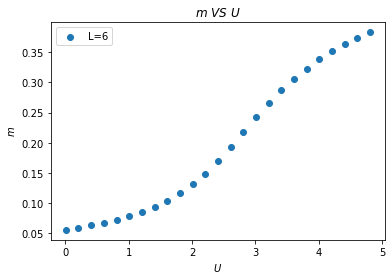

In [ ]:
plt.scatter(U_lst,m_lst,label='L=6')
plt.title(r'$m\ VS\ U$')
plt.xlabel(r'$U$')
plt.ylabel(r'$m$')
plt.legend()

#### 2.2 Gradient-descent algorithm

In [ ]:
def getdedm(U,Ne,e0,m):
    '''
    return the derivative dE/dm for gradient descend
    '''
    dedm = -2*(U**2)*m*(1/np.sqrt((m**2)*(U**2)+e0)).sum()/Ne + 2*U*m
    return dedm

def gete(U,Ne,e0,m):
    '''
    get energy
    '''
    e = -2*(np.sqrt((m**2)*(U**2)+e0)).sum()/Ne+U/2+U*m**2      
    return e

In [ ]:
Ulist = np.arange(0.1,5,0.1)
Llist = [30,60,90,120,150]
alpha=0.1

e_end = np.inf*np.ones((len(Llist),len(Ulist)))
m_end = np.zeros((len(Llist),len(Ulist)))
itr_end = np.zeros((len(Llist),len(Ulist)))

for i in range(len(Llist)):
    L = Llist[i]
    Ne=2*L**2
    e0 = np.zeros((L,L))
    for kx_point in range(L):
        for ky_point in range(L):
            k=kx_point*np.array([1/2,np.sqrt(3)/2])+ky_point*np.array([1/2,-np.sqrt(3)/2])/L*2*np.pi/np.sqrt(3)*2 #generate k vectors
            dot1 = np.dot(k,np.array([np.sqrt(3)/2,1/2]))
            dot2 = np.dot(k,np.array([np.sqrt(3)/2,-1/2]))
            e0[kx_point,ky_point]=abs(1+np.exp(-1j*dot1*2*np.pi)+np.exp(-1j*dot2))**2
    m=0
    for j in range(len(Ulist)):
        U = Ulist[j]
        m+=0.0005*np.random.random()
        error=1
        itr=0
        while abs(error)>10**-8:
            error = alpha*getdedm(U,Ne,e0,m)
            m -= error
            itr += 1
        e_end[i,j] = gete(U,Ne,e0,m)
        m_end[i,j] = abs(m)
        itr_end[i,j] = itr

        
            

Here a random perturbation is added to m before it enters next round of iteration.  This allows us to use the convergent result from the last $U$ to speed up the convergence, and at the same time eliminates the posibility of getting a local maximum instead of minimum.

Plot the result and compare with the literature value, $U_c\approx 2.23$ [[2](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.101.125103)] where the phase transition between the paramagnetic semimetal and the antiferromagnetic insulator happens.

Text(0, 0.5, '$m$')

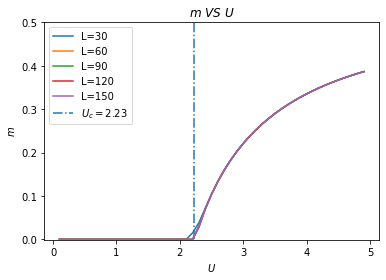

In [ ]:
plt.plot(Ulist,m_end[0])
plt.plot(Ulist,m_end[1])
plt.plot(Ulist,m_end[2])
plt.plot(Ulist,m_end[3])
plt.plot(Ulist,m_end[4])

plt.vlines(2.23,0,0.5,linestyles='-.')
plt.ylim(-0.001,0.5)
#plt.xlim(0.1,1)
le_here=['L='+str(L) for L in Llist]+['$U_c=2.23$']
plt.legend(le_here)
plt.title('$m\ VS\  U$')
plt.xlabel('$U$')
plt.ylabel('$m$')

From Ref [[2]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.101.125103), a mean-field expression for the  staggered magnetization for $U>U_c$is given by

$$
m_{\mathrm{s}}=\frac{\sqrt{\pi} v_F}{\sqrt{2} U}\left(\frac{U}{U_c}-\frac{U_c}{U}\right).
$$

It turns out that our result suggests an $1/4$ revision of the coefficient.


In [ ]:
Y = []
X = np.arange(2.23,5,0.05)
Uc = 2.23
for ix in X:
    y = 2*Uc*(1/Uc-Uc/ix**2)*1/4
    Y.append(y)

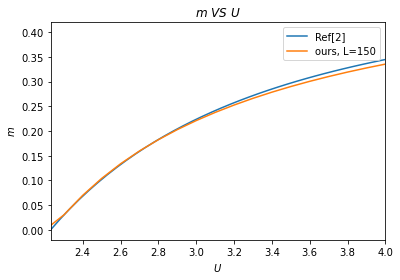

In [ ]:
plt.plot(X,Y,label='Ref[2]')
plt.plot(Ulist,m_end[4],label='ours, L=150')
plt.title('$m\ VS\  U$')
plt.xlabel('$U$')
plt.ylabel('$m$')
plt.xlim(2.23,4)
plt.legend()

Here we can also check the criticle exponents $\beta$ for the gap, $\Delta$. Near $U_c$, the scaling behavior is:

$$
\Delta = Um_s \sim (U-U_c)^{\beta}.
$$

Our results suggests that $\beta = 1$.

In [ ]:
delta_end = np.zeros((len(Llist),len(Ulist)))
delta_end[:] = m_end[:]
for i in range(delta_end.shape[0]):
    delta_end[i] = delta_end[i]*Ulist

Text(0, 0.5, '$\\Delta$')

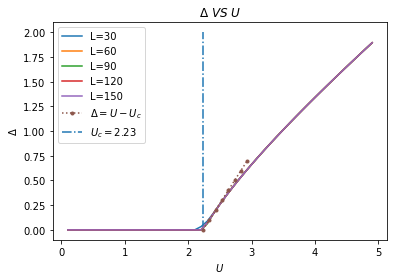

In [ ]:
plt.plot(Ulist,delta_end[0])
plt.plot(Ulist,delta_end[1])
plt.plot(Ulist,delta_end[2])
plt.plot(Ulist,delta_end[3])
plt.plot(Ulist,delta_end[4])
plt.vlines(2.23,0,2,linestyles='-.')

X_lst = np.arange(2.23,3,0.1)
Y_lst = []
for ix in X_lst:
    y = ix-2.23
    Y_lst.append(y)
plt.plot(X_lst,Y_lst,marker='.',linestyle=':')
#plt.ylim(-0.001,0.5)
#plt.xlim(0.1,1)
le_here=['L='+str(L) for L in Llist]+['$\Delta=U-U_c$']+['$U_c=2.23$']
plt.legend(le_here)
plt.title('$\Delta \ VS\  U$')
plt.xlabel('$U$')
plt.ylabel('$\Delta$')


# To be continued